In [32]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter, defaultdict

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df=pd.read_csv('../datasets/llm_bert_clusters.csv')

In [3]:
df=df[df['naed']!=0].copy()

# Row Extraction and transformation

In [4]:
df.head(2)

,Unnamed: 0,title,NER_list,filtered_verbs,umap_x,umap_y,dish_type_response,naed,naed_label,hier,hier_label
0,0,""" Bar"" Cheese",['velveeta cheese' 'mayonnaise' 'horseradish' ...,['pan' 'add' 'stir' 'add' 'stir' 'cool' 'refri...,5.577381,0.643841,"RATIONALE: cheesy dip, mayonnaise-based, horse...",4,"Salads, Slaws, Dips & Dressings",4,"Salads, Slaws, Dips & Dressings"
1,1,""" Barber's"" Chewy Vanilla & Salted Butter Toffee",['icing sugar' 'milk' 'corn syrup' 'vanilla be...,['pot' 'stir' 'reduce' 'remove' 'stir' 'reach'...,-0.811124,1.096539,"RATIONALE: Desserts, Cookies & Cakes (toffee i...",2,"Desserts, Cookies & Cakes",2,"Desserts, Cookies & Cakes"


In [6]:
df['rationale_text'] = df['dish_type_response'].str.extract(r'RATIONALE:\s*(.*?)\s*NUMBER', expand=False).astype(str)

In [7]:
for i in range(2):
  print(df['dish_type_response'].iloc[i],"\n")
  print(f'Rationale for{i}')
  print(df['rationale_text'].iloc[i])

RATIONALE: cheesy dip, mayonnaise-based, horseradish, tabasco, Worcestershire sauce
NUMBER = 4

This recipe falls under the "Dips, Slaws, Dressings" category (number 4) as it is 

Rationale for0
cheesy dip, mayonnaise-based, horseradish, tabasco, Worcestershire sauce
RATIONALE: Desserts, Cookies & Cakes (toffee is a type of candy, sweet treat)
NUMBER = 2

This recipe is for making a dessert called "Barber's chewy vanilla & salted butter toffee." The 

Rationale for1
Desserts, Cookies & Cakes (toffee is a type of candy, sweet treat)


In [8]:
# # Extract text after 'NUMBER'
# df['after_number_text'] = df['dish_type_response'].str.extract(r'NUMBER\s*=\s*\d+\s*(.*)', expand=False)
# df['after_number_text'] = df['after_number_text'].fillna(' ')

In [9]:
# # Extract text before 'RATIONALE'
# df['before_rationale_text'] = df['dish_type_response'].str.extract(r'^(.*?)\s*RATIONALE', expand=False)
# df['before_rationale_text'] = df['before_rationale_text'].fillna(' ')

In [11]:
# df['combined_text']=df['before_rationale_text']+df['rationale_text']+df['after_number_text']

In [13]:
def fix_ner_list(val):
    if isinstance(val, str):
        val = val.strip("[]")
        parts = re.findall(r"'(.*?)'", val)
        return [p.strip() for p in parts]
    return val

df['NER_list'] = df['NER_list'].apply(fix_ner_list)
df['filtered_verbs']=df['filtered_verbs'].apply(fix_ner_list)

# Analysis

In [15]:
df['verbs_set']=df['filtered_verbs'].apply(set)

In [17]:
prompt_keywords = {
    1: {"breakfast bakes, breads & pancakes","breakfast", "bakes", "breads", "pancakes", "waffles", "morning", "cornbread"},
    2: {"desserts, cookies & cakes","desserts", "cookies", "cakes", "sweet", "treats", "pies", "sweet sauces", "puddings", "custards", "creamy"},
    3: {"drinks, punches & fruits treats","drinks", "punches", "fruit", "beverages", "smoothies", "juices"},
    4: {"salads, slaws, dips & dressing","salads", "slaws", "dips", "dressings", "spreads", "condiments"},
    5: {"pasta & vegetables casseroles/bakes","pasta", "vegetable", "casseroles", "bakes", "stuffings"},
    6: {"soups, stews & one-pots","soups", "stews", "one-pots", "chilis", "broths"},
    7: {"meat & fish mains","meat", "fish", "mains", "protein", "chicken", "beef", "pork", "salmon", "shrimp"},
}

all_prompt_keywords = {word for keywords in prompt_keywords.values() for word in keywords}

## One-to-One matching with words in `ingredients`, `verbs_set`, and `title`

We are refining the rationale of the LLM responses and then we are checking whether the features mentioned are within ingredients, verbs, titles, prompt or in anything else.

In [18]:
import re

def extract_rationale_phrases(rationale_text):
    rationale_text = rationale_text.lower()
    # removing parenthesis
    rationale_text = re.sub(r'[\(\)]', '', rationale_text)
    # splitting on commas
    phrases = [phrase.strip() for phrase in rationale_text.split(',') if phrase.strip()]
    return phrases

def analyze_rationale(row):
    rationale = row['rationale_text']
    rationale_phrases = extract_rationale_phrases(rationale)
    
    ingredients_mentioned = []
    used_phrases = set()
    for ing in row['NER_list']:
        ing_lower = ing.lower()
        for phrase in rationale_phrases:
            if ing_lower in phrase and phrase not in used_phrases:
                ingredients_mentioned.append(ing)
                used_phrases.add(phrase)
                break

    lemmatizer = WordNetLemmatizer()

    def lemmatize_phrase(phrase):
        words = re.findall(r'\b\w+\b', phrase.lower())
        return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])  # use verb POS

    # Lemmatize rationale for matching of verbs
    lemmatized_phrases = [lemmatize_phrase(phrase) for phrase in rationale_phrases]

    # lemmatized verbs
    verbs_mentioned = []
    for verb in row['verbs_set']:
        verb_lemma = lemmatizer.lemmatize(verb.lower(), pos='v')
        for i, lemmatized_phrase in enumerate(lemmatized_phrases):
            if verb_lemma in lemmatized_phrase and rationale_phrases[i] not in used_phrases:
                verbs_mentioned.append(verb)
                used_phrases.add(rationale_phrases[i])  # mark original phrase as used
                break

    # Title
    title_words_mentioned = []
    title_words = re.sub(r"[^\w\s]", "", row['title'].lower()).split()
    for word in title_words:
        for phrase in rationale_phrases:
            if word in phrase and phrase not in used_phrases:
                title_words_mentioned.append(word)
                used_phrases.add(phrase)
                break

    # Prompt
    prompt_mentioned = []
    for word in all_prompt_keywords:
        for phrase in rationale_phrases:
            if word in phrase and phrase not in used_phrases:
                prompt_mentioned.append(word)
                used_phrases.add(phrase)
                break

    # Other
    other_mentioned = [phrase for phrase in rationale_phrases if phrase not in used_phrases and len(phrase) > 2]

    return pd.Series({
        'ingredients_mentioned': ingredients_mentioned,
        'verbs_mentioned': verbs_mentioned,
        'title_words_mentioned': title_words_mentioned,
        'prompt_mentioned': prompt_mentioned,
        'other_mentioned': other_mentioned
    })

In [19]:
df_analysis = df.apply(analyze_rationale, axis=1)
df = pd.concat([df, df_analysis], axis=1)

In [25]:
for i in range(2):
  # df[['dish_type_response','NER_list','rationale_text','ingredients_mentioned']]
  print(df['dish_type_response'].iloc[i])
  print(df['NER_list'].iloc[i])
  print(df['rationale_text'].iloc[i])
  print(df['ingredients_mentioned'].iloc[i])
  print(df['verbs_mentioned'].iloc[i])
  print(df['title_words_mentioned'].iloc[i])
  print(df['prompt_mentioned'].iloc[i])
  print(df['other_mentioned'].iloc[i])
  print('\n')

RATIONALE: cheesy dip, mayonnaise-based, horseradish, tabasco, Worcestershire sauce
NUMBER = 4

This recipe falls under the "Dips, Slaws, Dressings" category (number 4) as it is
['velveeta cheese', 'mayonnaise', 'horseradish', 'tabasco sauce', 'worcestershire sauce']
cheesy dip, mayonnaise-based, horseradish, tabasco, Worcestershire sauce
['mayonnaise', 'horseradish', 'worcestershire sauce']
[]
[]
[]
['cheesy dip', 'tabasco']


RATIONALE: Desserts, Cookies & Cakes (toffee is a type of candy, sweet treat)
NUMBER = 2

This recipe is for making a dessert called "Barber's chewy vanilla & salted butter toffee." The
['icing sugar', 'milk', 'corn syrup', 'vanilla bean', 'butter']
Desserts, Cookies & Cakes (toffee is a type of candy, sweet treat)
[]
[]
['toffee']
['sweet', 'desserts']
[]




## One-to-Many matching
Matching ingredients not to the specific ingredients in the row, but to all other ingredients and to all other verbs, so at a global level.

In [21]:
lemmatizer = WordNetLemmatizer()

# global sets
all_ingredients = set(ing.lower() for sublist in df['NER_list'] for ing in sublist)
all_verbs = set(verb.lower() for sublist in df['filtered_verbs'] for verb in sublist)
all_titles = set()
for title in df['title']:
    title_clean = re.sub(r'[^\w\s]', '', title.lower())
    all_titles.update(title_clean.split())
all_prompt_keywords = {word for keywords in prompt_keywords.values() for word in keywords}


all_ingredients = {ing for ing in all_ingredients if len(ing) >= 3}
all_verbs = {verb for verb in all_verbs if len(verb) >= 3}
all_titles = {word for word in all_titles if len(word) >= 3}

# split rationalE
def tokenize_rationale(text):
    text = text.lower()
    parts = re.split(r'[,\n;]', text)
    tokens = []
    for part in parts:
        part = re.sub(r'[^\w\s]', '', part)
        tokens.extend(part.split())
    return [word for word in tokens if len(word) > 2] # Keeping words that are longer than 2 characters

# categorization
def analyze_rationale_all(row):
    rationale_words = tokenize_rationale(row['rationale_text'])

    assigned = set()

    # ingredients
    ingredients_mentioned = set([word for word in rationale_words
                             if word in all_ingredients and word not in assigned])
    assigned.update(ingredients_mentioned)

    # lemmatized verbs
    verbs_mentioned = []
    for word in rationale_words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        if lemma in all_verbs and word not in assigned:
            verbs_mentioned.append(word)
            assigned.add(word)

    # titles
    title_words_mentioned = [word for word in rationale_words
                             if word in all_titles and word not in assigned]
    assigned.update(title_words_mentioned)

    return pd.Series({
        'all_ingredients_mentioned': ingredients_mentioned,
        'all_verbs_mentioned': verbs_mentioned,
        'all_titles_mentioned': title_words_mentioned
    })

In [22]:
df_analysis = df.apply(analyze_rationale_all, axis=1)
df = pd.concat([df, df_analysis], axis=1)

In [24]:
for i in range(2):
    print(f"--- Row {i+1} ---")
    print(f"Dish Type Response (Length: {len(df['dish_type_response'].iloc[i])}): {df['dish_type_response'].iloc[i]}")
    print(f"NER List (Length: {len(df['NER_list'].iloc[i])}): {df['NER_list'].iloc[i]}")
    print(f"Rationale Text (Length: {len(df['rationale_text'].iloc[i])}): {df['rationale_text'].iloc[i]}")
    print(f"All Ingredients Mentioned (Length: {len(df['all_ingredients_mentioned'].iloc[i])}): {df['all_ingredients_mentioned'].iloc[i]}")
    print(f"All Verbs Mentioned (Length: {len(df['all_verbs_mentioned'].iloc[i])}): {df['all_verbs_mentioned'].iloc[i]}")
    print(f"All Titles Mentioned (Length: {len(df['all_titles_mentioned'].iloc[i])}): {df['all_titles_mentioned'].iloc[i]}")
    print(f"Other Mentioned (Length: {len(df['other_mentioned'].iloc[i])}): {df['other_mentioned'].iloc[i]}")
    print(f"Prompt Mentioned (Length: {len(df['prompt_mentioned'].iloc[i])}): {df['prompt_mentioned'].iloc[i]}")
    print('\n')

--- Row 1 ---
Dish Type Response (Length: 177): RATIONALE: cheesy dip, mayonnaise-based, horseradish, tabasco, Worcestershire sauce
NUMBER = 4

This recipe falls under the "Dips, Slaws, Dressings" category (number 4) as it is
NER List (Length: 5): ['velveeta cheese', 'mayonnaise', 'horseradish', 'tabasco sauce', 'worcestershire sauce']
Rationale Text (Length: 72): cheesy dip, mayonnaise-based, horseradish, tabasco, Worcestershire sauce
All Ingredients Mentioned (Length: 4): {'tabasco', 'horseradish', 'sauce', 'worcestershire'}
All Verbs Mentioned (Length: 1): ['dip']
All Titles Mentioned (Length: 1): ['cheesy']
Other Mentioned (Length: 2): ['cheesy dip', 'tabasco']
Prompt Mentioned (Length: 0): []


--- Row 2 ---
Dish Type Response (Length: 185): RATIONALE: Desserts, Cookies & Cakes (toffee is a type of candy, sweet treat)
NUMBER = 2

This recipe is for making a dessert called "Barber's chewy vanilla & salted butter toffee." The
NER List (Length: 5): ['icing sugar', 'milk', 'corn syrup

# Feature Importance

## Global

In [27]:
global_ingredient_counter = Counter(word for words in df['all_ingredients_mentioned'] for word in words)
global_verb_counter = Counter(word for words in df['all_verbs_mentioned'] for word in words)
global_title_counter = Counter(word for words in df['all_titles_mentioned'] for word in words)
global_other_counter = Counter(word for words in df['other_mentioned'] for word in words)
global_prompt_counter = Counter(word for words in df['prompt_mentioned'] for word in words)

In [28]:
# total counts per category
ingredient_total = sum(global_ingredient_counter.values())
verb_total       = sum(global_verb_counter.values())
title_total      = sum(global_title_counter.values())
prompt_total     = sum(global_prompt_counter.values())
other_total      = sum(global_other_counter.values())

# total all
grand_total = ingredient_total + verb_total + title_total + prompt_total + other_total

# relative weights
relative_weights = {
    'ingredients': ingredient_total / grand_total,
    'verbs':       verb_total       / grand_total,
    'titles':      title_total      / grand_total,
    'prompts':     prompt_total     / grand_total,
    'others':      other_total      / grand_total
}

# sort by highest relative weight
relative_weights = dict(sorted(relative_weights.items(), key=lambda x: x[1], reverse=True))

for category, weight in relative_weights.items():
    print(f"{category}: {weight:.2%}")

ingredients: 51.48%
titles: 18.73%
verbs: 14.15%
others: 10.53%
prompts: 5.11%


## Local

In [29]:
label_counters = {}

for label, group in df.groupby('naed'):
    ingredient_counter = Counter(word for words in group['ingredients_mentioned'] for word in words)
    verb_counter       = Counter(word for words in group['verbs_mentioned'] for word in words)
    title_counter      = Counter(word for words in group['title_words_mentioned'] for word in words)
    prompt_counter     = Counter(word for words in group['prompt_mentioned'] for word in words)
    other_counter      = Counter(word for words in group['other_mentioned'] for word in words)

    # sum of totals
    ingredient_total = sum(ingredient_counter.values())
    verb_total       = sum(verb_counter.values())
    title_total      = sum(title_counter.values())
    prompt_total     = sum(prompt_counter.values())
    other_total      = sum(other_counter.values())

    grand_total = ingredient_total + verb_total + title_total + prompt_total + other_total

    # relative weights
    relative_weights = {
        'ingredients': ingredient_total / grand_total if grand_total else 0,
        'verbs':       verb_total       / grand_total if grand_total else 0,
        'titles':      title_total      / grand_total if grand_total else 0,
        'prompts':     prompt_total     / grand_total if grand_total else 0,
        'others':      other_total      / grand_total if grand_total else 0
    }

    label_counters[label] = relative_weights

# summary table
weights_df = pd.DataFrame(label_counters).T  # Transpose for labels as rows
weights_df = weights_df[[ 'ingredients', 'verbs', 'titles', 'prompts', 'others' ]]  # Ensure consistent column order

# percentages
weights_percent = weights_df.applymap(lambda x: f"{x:.2%}")

print(weights_percent)

  ingredients   verbs  titles prompts  others
1      48.70%  13.72%  17.44%   4.41%  15.73%
2      44.57%  14.48%  16.13%  10.16%  14.66%
3      36.00%  11.05%  16.43%  18.14%  18.38%
4      46.28%   8.56%  17.11%   7.34%  20.71%
5      49.10%  12.05%  14.81%   7.06%  16.99%
6      52.22%  11.06%  16.40%   3.75%  16.58%
7      48.42%  11.21%  14.13%  10.47%  15.77%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8880\2780114000.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weights_percent = weights_df.applymap(lambda x: f"{x:.2%}")


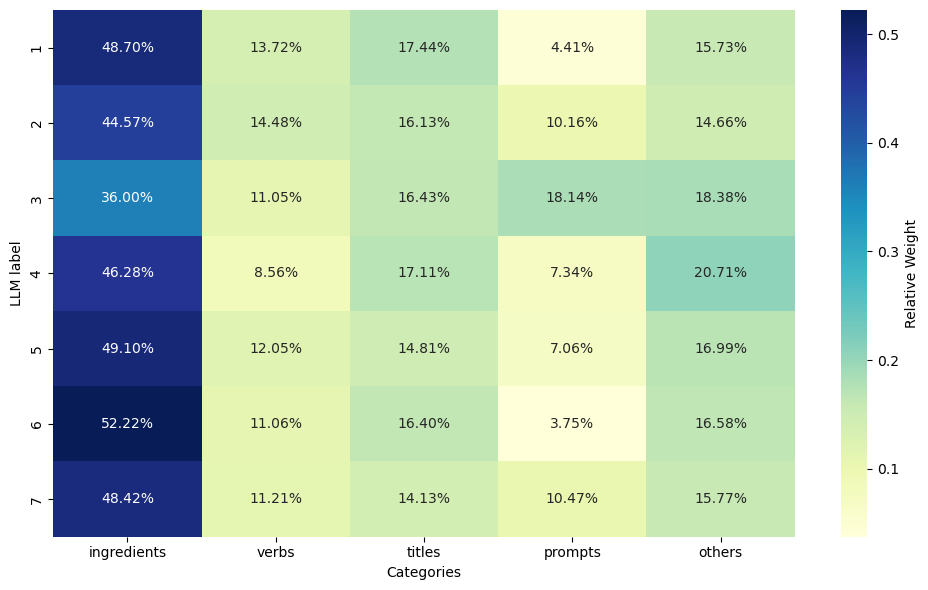

In [30]:
weights_numeric = weights_df.copy()
weights_numeric = weights_numeric.sort_index()

plt.figure(figsize=(10, 6))
sns.heatmap(weights_numeric, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Relative Weight'})
plt.ylabel("LLM label")
plt.xlabel("Categories")
plt.tight_layout()
plt.savefig('../images/lmm_relative_perc.png')
plt.show()

# Searching for specific words

In [31]:
def get_top_n_words(counter, n=10):
    return counter.most_common(n)

top_n = 10
label_word_summary = {}

for label, group in df.groupby('naed'):
    ingredient_counter = Counter(word for words in group['ingredients_mentioned'] for word in words)
    verb_counter       = Counter(word for words in group['verbs_mentioned'] for word in words)
    title_counter      = Counter(word for words in group['title_words_mentioned'] for word in words)
    prompt_counter     = Counter(word for words in group['prompt_mentioned'] for word in words)
    other_counter      = Counter(word for words in group['other_mentioned'] for word in words)
    
    label_word_summary[label] = {
        'top_ingredients': get_top_n_words(ingredient_counter, top_n),
        'top_verbs': get_top_n_words(verb_counter, top_n),
        'top_title_words': get_top_n_words(title_counter, top_n),
        'top_prompt_words': get_top_n_words(prompt_counter, top_n),
        'top_other_words': get_top_n_words(other_counter, top_n)
    }

for label, summary in label_word_summary.items():
    print(f"\n=== Label: {label} ===")
    for category, top_words in summary.items():
        print(f"\n{category}:")
        for word, freq in top_words:
            print(f"  {word}: {freq}")


=== Label: 1 ===

top_ingredients:
  sugar: 821
  flour: 756
  eggs: 658
  milk: 432
  butter: 419
  baking powder: 403
  salt: 374
  bread: 323
  egg: 265
  cinnamon: 238

top_verbs:
  bake: 1403
  serve: 106
  cook: 104
  add: 75
  rise: 71
  fry: 66
  stir: 65
  toast: 60
  microwave: 57
  make: 50

top_title_words:
  bread: 388
  muffins: 191
  cookies: 168
  rolls: 120
  cheese: 114
  pancakes: 101
  biscuits: 84
  cake: 74
  breakfast: 67
  corn: 64

top_prompt_words:
  breads: 282
  breakfast: 188
  sweet: 99
  cakes: 81
  bakes: 65
  vegetable: 55
  cookies: 55
  fruit: 47
  dips: 12
  cornbread: 12

top_other_words:
  bread: 292
  bake: 255
  baking: 218
  cheese: 143
  side dish: 94
  sugar: 84
  appetizer: 69
  savory: 68
  cinnamon: 65
  nuts: 64

=== Label: 2 ===

top_ingredients:
  sugar: 1613
  eggs: 784
  flour: 730
  milk: 671
  vanilla: 662
  butter: 638
  brown sugar: 359
  cinnamon: 309
  nuts: 299
  baking powder: 271

top_verbs:
  bake: 1459
  pudding: 233
  stir

# Log-Odd

In [33]:
top_n = 10

# total word frequencies per column across all labels
columns = ['ingredients_mentioned', 'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned', 'other_mentioned']
total_freqs = {col: Counter(word for words in df[col] for word in words) for col in columns}
total_counts = {col: sum(freqs.values()) for col, freqs in total_freqs.items()}

# Step 2: Compute word frequencies per label per column
label_freqs = defaultdict(lambda: {col: Counter() for col in columns})
label_counts = defaultdict(lambda: {col: 0 for col in columns})

for label, group in df.groupby('naed'):
    for col in columns:
        col_words = [word for words in group[col] for word in words]
        label_freqs[label][col] = Counter(col_words)
        label_counts[label][col] = sum(label_freqs[label][col].values())

# compute log-odds and select
top_words_by_log_odds = defaultdict(lambda: {col: [] for col in columns})

for label in label_freqs:
    for col in columns:
        col_total_count = total_counts[col]
        word_scores = {}
        for word, freq_in_label in label_freqs[label][col].items():
            total_freq = total_freqs[col][word]

            p_label = freq_in_label / label_counts[label][col] if label_counts[label][col] > 0 else 0

            non_label_count = col_total_count - label_counts[label][col]
            freq_outside_label = total_freq - freq_in_label
            p_not_label = freq_outside_label / non_label_count if non_label_count > 0 else 0

            # Log-odds score (with small constant)
            eps = 1e-6
            log_odds = np.log((p_label + eps) / (p_not_label + eps))
            word_scores[word] = log_odds

        # top n
        sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_words_by_log_odds[label][col] = sorted_words

for label, col_dict in top_words_by_log_odds.items():
    print(f"\n=== Label: {label} ===")
    for col, word_list in col_dict.items():
        print(f"\nTop {top_n} by log-odds in {col}:")
        for word, score in word_list:
            print(f"  {word}: {score:.3f}")


=== Label: 1 ===

Top 10 by log-odds in ingredients_mentioned:
  warm water: 5.928
  rye flour: 5.928
  yeast: 5.911
  vegetable shortening: 5.641
  anise seed: 5.641
  bagels: 5.641
  warm milk: 5.238
  active dry yeast: 5.238
  whole wheat tortillas: 5.238
  bran: 4.604

Top 10 by log-odds in verbs_mentioned:
  lay: 6.501
  light: 5.809
  plate: 5.809
  alternate: 5.809
  inch: 5.809
  want: 5.809
  rise: 4.700
  knead: 3.838
  shorten: 2.920
  toast: 2.589

Top 10 by log-odds in title_words_mentioned:
  pancake: 8.824
  waffle: 8.131
  popovers: 8.051
  scones: 7.869
  loaves: 7.764
  doughnuts: 7.646
  hush: 7.358
  bran: 7.176
  donuts: 6.953
  yeast: 6.953

Top 10 by log-odds in prompt_mentioned:
  morning: 8.886
  waffles: 8.732
  breads: 7.340
  breakfast: 5.147
  cakes: 4.844
  cornbread: 4.183
  bakes: 3.862
  pies: 1.297
  cookies: 0.412
  pork: 0.227

Top 10 by log-odds in other_mentioned:
  yeast: 9.037
  toasted: 7.867
  baked goods: 7.867
  muffins: 7.749
  quick bread:

# Log-Odd aggregate and visual

In [34]:
columns = ['ingredients_mentioned', 'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned', 'other_mentioned']

# total frequency
total_freqs = {col: Counter(word for words in df[col] for word in words) for col in columns}
total_counts = {col: sum(c.values()) for col, c in total_freqs.items()}

# per-label frequency
label_freqs = defaultdict(lambda: {col: Counter() for col in columns})
label_counts = defaultdict(lambda: {col: 0 for col in columns})

for label, group in df.groupby('naed'):
    for col in columns:
        all_words = [word for words in group[col] for word in words]
        label_freqs[label][col] = Counter(all_words)
        label_counts[label][col] = sum(label_freqs[label][col].values())

# average log-odds per label per column
avg_log_odds_table = pd.DataFrame(index=label_freqs.keys(), columns=columns)

for label in label_freqs:
    for col in columns:
        col_total = total_counts[col]
        label_total = label_counts[label][col]
        word_scores = []

        for word, freq_label in label_freqs[label][col].items():
            total_freq = total_freqs[col][word]
            non_label_total = col_total - label_total
            freq_not_label = total_freq - freq_label

            eps = 1e-6
            p_label = freq_label / label_total if label_total > 0 else 0
            p_not_label = freq_not_label / non_label_total if non_label_total > 0 else 0

            log_odds = np.log((p_label + eps) / (p_not_label + eps))
            word_scores.append(log_odds)

        # average log-odds
        avg_log_odds = np.mean(word_scores) if word_scores else 0.0
        avg_log_odds_table.loc[label, col] = avg_log_odds

avg_log_odds_table = avg_log_odds_table.astype(float)
avg_log_odds_table = avg_log_odds_table.sort_index()

print(avg_log_odds_table.round(3))

   ingredients_mentioned  verbs_mentioned  title_words_mentioned  \
1                  0.203            0.222                  1.629   
2                  0.913            0.101                  2.018   
3                  1.351            0.920                  2.910   
4                  0.687            0.478                  1.342   
5                  0.537           -0.180                  1.847   
6                  0.597            0.476                  1.594   
7                  0.766            0.351                  2.066   

   prompt_mentioned  other_mentioned  
1             1.148            2.745  
2            -0.926            3.342  
3             0.438            3.511  
4             0.118            2.293  
5            -0.575            2.403  
6             0.987            2.486  
7             0.920            3.130  


In [35]:
avg_log_odds_table.rename(columns={'ingredients_mentioned':'ingredients','verbs_mentioned':'verbs','title_words_mentioned':'title','prompt_mentioned':'prompt','other_mentioned':'other'},inplace=True)

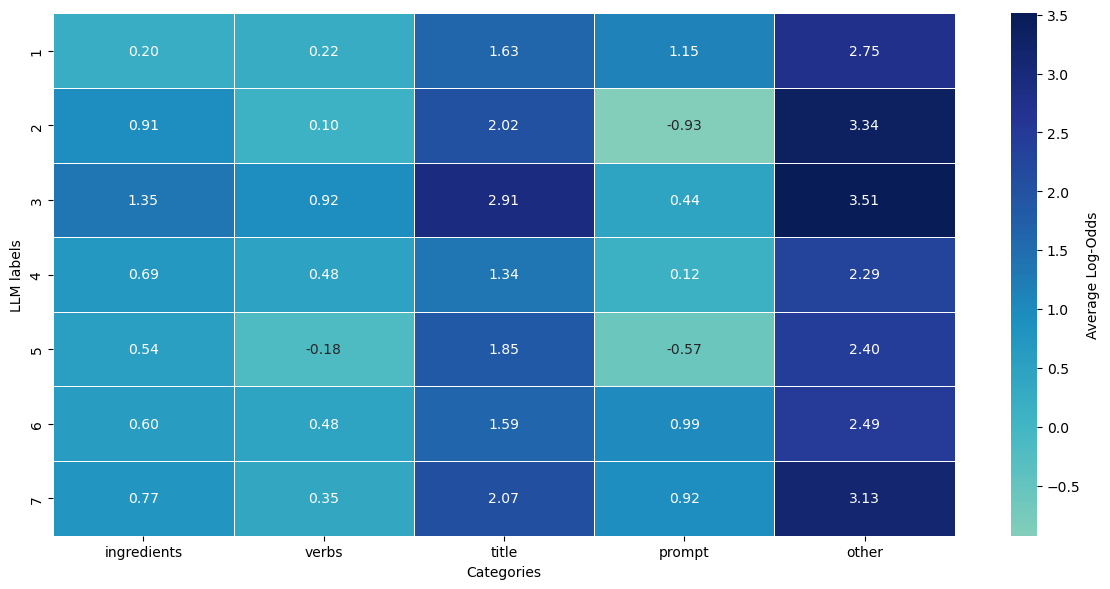

In [37]:
plt.figure(figsize=(12, 6))
sns.heatmap(avg_log_odds_table, annot=True, fmt=".2f", cmap="YlGnBu", center=0, linewidths=0.5, cbar_kws={"label": "Average Log-Odds"})

plt.xlabel("Categories")
plt.ylabel("LLM labels")
plt.tight_layout()

plt.savefig('../images/lmm_log_odd.png')
plt.show()

# Table creation

Storing the results for later use.

In [38]:
columns = ['ingredients_mentioned', 'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned', 'other_mentioned']
logodd_columns = ['ingredients_logodd', 'verbs_logodd', 'title_logodd', 'prompt_logodd', 'other_logodd']

# label frequencies
total_freqs = {col: Counter(word for words in df[col] for word in words) for col in columns}
total_counts = {col: sum(c.values()) for col, c in total_freqs.items()}

label_freqs = defaultdict(lambda: {col: Counter() for col in columns})
label_counts = defaultdict(lambda: {col: 0 for col in columns})

for label, group in df.groupby('naed'):
    for col in columns:
        words = [word for sub in group[col] for word in sub]
        label_freqs[label][col] = Counter(words)
        label_counts[label][col] = sum(label_freqs[label][col].values())

# compute log-odds
logodd_lookup = defaultdict(lambda: {col: dict() for col in columns})
eps = 1e-6

for label in label_freqs:
    for col in columns:
        label_total = label_counts[label][col]
        col_total = total_counts[col]
        for word, freq_label in label_freqs[label][col].items():
            total_freq = total_freqs[col][word]
            freq_not_label = total_freq - freq_label
            non_label_total = col_total - label_total

            p_label = freq_label / label_total if label_total > 0 else 0
            p_not_label = freq_not_label / non_label_total if non_label_total > 0 else 0

            logodd = np.log((p_label + eps) / (p_not_label + eps))
            logodd_lookup[label][col][word] = logodd

# log-odds lists
def compute_row_logodds(row):
    label = row['naed']
    result = {}
    for col, log_col in zip(columns, logodd_columns):
        result[log_col] = [logodd_lookup[label][col].get(word, 0.0) for word in row[col]]
    return pd.Series(result)

df[logodd_columns] = df.apply(compute_row_logodds, axis=1)

In [39]:
df[df['prompt_mentioned'].apply(lambda x: 'drinks' in x)][['naed','ingredients_mentioned', 'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned', 'other_mentioned','ingredients_logodd', 'verbs_logodd', 'title_logodd', 'prompt_logodd', 'other_logodd']].head(2)

,naed,ingredients_mentioned,verbs_mentioned,title_words_mentioned,prompt_mentioned,other_mentioned,ingredients_logodd,verbs_logodd,title_logodd,prompt_logodd,other_logodd
2,3,[ginger],[],[],[drinks],[],[1.3165664715567835],[],[],[7.575182930425504],[]
12,2,"[coffee, whipped cream]",[blend],[],[drinks],"[ice cream, syrup, dessert]","[0.6005930283740826, 1.6754681850454356]",[0.375832838988868],[],[-4.62411124903348],"[2.2092829103428153, 2.5643029728228925, 5.935..."


In [40]:
columns = ['ingredients_logodd', 'verbs_logodd', 'title_logodd', 'prompt_logodd', 'other_logodd']

for col in columns:
    df[f'avg_{col}'] = df[col].apply(lambda x: np.mean(x) if x else np.nan)

In [41]:
df.columns

Index(['Unnamed: 0', 'title', 'NER_list', 'filtered_verbs', 'umap_x', 'umap_y',
       'dish_type_response', 'naed', 'naed_label', 'hier', 'hier_label',
       'rationale_text', 'verbs_set', 'ingredients_mentioned',
       'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned',
       'other_mentioned', 'all_ingredients_mentioned', 'all_verbs_mentioned',
       'all_titles_mentioned', 'ingredients_logodd', 'verbs_logodd',
       'title_logodd', 'prompt_logodd', 'other_logodd',
       'avg_ingredients_logodd', 'avg_verbs_logodd', 'avg_title_logodd',
       'avg_prompt_logodd', 'avg_other_logodd'],
      dtype='object')

In [42]:
df[df['prompt_mentioned'].apply(lambda x: 'drinks' in x)][['naed','ingredients_mentioned', 'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned', 'other_mentioned','ingredients_logodd', 'verbs_logodd', 'title_logodd', 'prompt_logodd', 'other_logodd','avg_ingredients_logodd', 'avg_verbs_logodd', 'avg_title_logodd',
       'avg_prompt_logodd', 'avg_other_logodd']].head(2)

,naed,ingredients_mentioned,verbs_mentioned,title_words_mentioned,prompt_mentioned,other_mentioned,ingredients_logodd,verbs_logodd,title_logodd,prompt_logodd,other_logodd,avg_ingredients_logodd,avg_verbs_logodd,avg_title_logodd,avg_prompt_logodd,avg_other_logodd
2,3,[ginger],[],[],[drinks],[],[1.3165664715567835],[],[],[7.575182930425504],[],1.316566,NaN,NaN,7.575183,NaN
12,2,"[coffee, whipped cream]",[blend],[],[drinks],"[ice cream, syrup, dessert]","[0.6005930283740826, 1.6754681850454356]",[0.375832838988868],[],[-4.62411124903348],"[2.2092829103428153, 2.5643029728228925, 5.935...",1.138031,0.375833,NaN,-4.624111,3.56963


In [43]:
df[['Unnamed: 0', 'title', 'NER_list', 'filtered_verbs',
       'dish_type_response', 'naed', 'naed_label', 'hier', 'hier_label',
       'rationale_text',
       'verbs_set', 'ingredients_mentioned',
       'verbs_mentioned', 'title_words_mentioned', 'prompt_mentioned',
       'other_mentioned','ingredients_logodd', 'verbs_logodd',
       'title_logodd', 'prompt_logodd', 'other_logodd','avg_ingredients_logodd', 'avg_verbs_logodd', 'avg_title_logodd',
       'avg_prompt_logodd', 'avg_other_logodd']].to_csv('../datasets/llm_logodds.csv')